In [22]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/SR code/Super_Resolution_model

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/SR code/Super_Resolution_model


In [ ]:
%cd /content/drive/MyDrive/image_dataset/
%mkdir /content/test_data
%mkdir /content/test_data/set_data
!unzip 'thermal_test_1116.zip' -d /content/test_data/set_data/test/

In [24]:
!python 'image_folder_create(dataset).py'

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
3193
3194
3195
3196
3197
3198
3199
3200
3201
3202
3203
3204
3205
3206
3207
3208
3209
3210
3211
3212
3213
3214
3215
3216
3217
3218
3219
3220
3221
3222
3223
3224
3225
3226
3227
3228
3229
3230
3231
3232
3233
3234
3235
3236
3237
3238
3239
3240
3241
3242
3243
3244
3245
3246
3247
3248
3249
3250
3251
3252
3253
3254
3255
3256
3257
3258
3259
3260
3261
3262
3263
3264
3265
3266
3267
3268
3269
3270
3271
3272
3273
3274
3275
3276
3277
3278
3279
3280
3281
3282
3283
3284
3285
3286
3287
3288
3289
3290
3291
3292
3293
3294
3295
3296
3297
3298
3299
3300
3301
3302
3303
3304
3305
3306
3307
3308
3309
3310
3311
3312
3313
3314
3315
3316
3317
3318
3319
3320
3321
3322
3323
3324
3325
3326
3327
3328
3329
3330
3331
3332
3333
3334
3335
3336
3337
3338
3339
3340
3341
3342
3343
3344
3345
3346
3347
3348
3349
3350
3351
3352
3353
3354
3355
3356
3357
3358
3359
3360
3361
3362
3363
3364
3365
3366
3367
3368
3369
3370
3371
3372
3373
3374
3375
3376
3377
3378
3379
3380
3381
3382
3383
3384
3385

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split,Subset
from torch.utils.data.sampler import SubsetRandomSampler, SequentialSampler
import torchvision
from torchvision import transforms
from torchvision.utils import save_image

import time
import math
from math import sqrt
from PIL import Image
import os
import random

from util.normalization import image_normalization_extract,imshow
from Dataset.image_dataset import imageDataset
from model.VDSR import VDSR
from model.SRCNN import SRCNN
from model.SRGAN import FeatureExtractor,ResidualBLock,GeneratorResNet,Discriminator
from vdsr_train import train,validate
from visualization.loss import Loss_and_metrics_visualization
from visualization.output import output_visualization

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(98) # Seed 고정

device = torch.device('cpu')
#path
# image_path = r"C:\Users\microsoft\Desktop\이삿짐\code\songsan_project\test\\"
image_path = '/content/test_data/set_data/test/'

image_size = (128,128)
num_epochs =10
batch_size = 8
Downsizing_factor = 4

In [59]:
# normalization
# nor_test_trans = transforms.Compose([transforms.Resize(image_size),
#                             transforms.ToTensor()])
# nor_test_data_set = torchvision.datasets.ImageFolder(root =image_path,
# 					transform = nor_test_trans,)
# nor_mean, nor_std = image_normalization_extract(nor_test_data_set)
nor_mean ,nor_std = ((0.5,0.5,0.5),(0.5,0.5,0.5))
inverse_mean = [-m/s for m, s in zip(nor_mean, nor_std)]
inverse_std = [1/s for s in nor_std]

# image Data load
#고해상도
HR_trans = transforms.Compose([transforms.Resize(image_size,interpolation=transforms.InterpolationMode.BICUBIC),
                            transforms.ToTensor(),
                            transforms.Normalize(nor_mean,nor_std)
                            ])
HR_data_set = torchvision.datasets.ImageFolder(root =image_path,
					transform = HR_trans,
                    target_transform=None)
#저해상도
LR_trans = transforms.Compose([transforms.Resize((image_size[0]//Downsizing_factor,image_size[1]//Downsizing_factor)),
                            transforms.ToTensor(),
                            transforms.Normalize(nor_mean, nor_std),
                            ])
LR_data_set = torchvision.datasets.ImageFolder(root =image_path,
					transform = LR_trans,
                    target_transform=None)
#저해상도-bicubic 보간
LR_BICUBIC_trans = transforms.Compose([transforms.Resize((image_size[0]//Downsizing_factor,image_size[1]//Downsizing_factor)),
                            transforms.Resize(image_size,interpolation=transforms.InterpolationMode.BICUBIC),
                            transforms.ToTensor(),
                            transforms.Normalize(nor_mean, nor_std),
                            ])
LR_BICUBIC_data_set = torchvision.datasets.ImageFolder(root =image_path,
					transform = LR_BICUBIC_trans,
                    target_transform=None)

trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize(nor_mean,nor_std)])
inverse_transform = transforms.Compose([
    transforms.Normalize(mean=inverse_mean, std=inverse_std),
    transforms.ToPILImage()  # 텐서를 PIL 이미지로 변환
])

# train valid test
validation_split = 0.2
test_split = 0.05

dataset_size=len(HR_data_set)
indices = list(range(dataset_size))
valid_split = int(np.floor(validation_split * dataset_size))
test_split = int(np.floor(test_split * dataset_size))

np.random.seed(98)
np.random.shuffle(indices)

train_idx,valid_idx,test_idx = indices[valid_split+test_split:],indices[:valid_split],indices[valid_split:valid_split+test_split]

#Dataset -> Dataloader
total_ds=imageDataset(LR_data_set, HR_data_set,LR_BICUBIC_data_set)

new_train_loader = DataLoader(Subset(total_ds,train_idx), batch_size=batch_size,shuffle=None)
new_valid_loader = DataLoader(Subset(total_ds,valid_idx), batch_size=batch_size,shuffle=None)
new_test_loader = DataLoader(Subset(total_ds,test_idx), batch_size=1,shuffle=None)

In [ ]:
#model load
model = VDSR().to(device)
#model = SRCNN().to(device)
model.load_state_dict(torch.load('./vdsr_save_model/test.pt'))
model.eval()

generator = GeneratorResNet()
generator.load_state_dict(torch.load('/content/drive/MyDrive/SR code/Super_Resolution_model/save_model/SRGAN/SRGAN_TEST11_16_thermal_image.pt',map_location=device))
generator=generator.to(device)
generator.eval()


In [8]:
pwd

'/content/drive/MyDrive/SR code/Super_Resolution_model'

In [9]:
cd /content/test_data/set_data/test/thermal_test_1116/

/content/test_data/set_data/test/thermal_test_1116


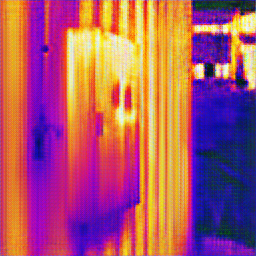

In [78]:
# 한장씩 확인

img = Image.open(r'/content/dataset_6/hr/image/4.png')
# img = trans(img)
# model.eval()
# with torch.no_grad():
#   output = img.unsqueeze(0).to(device)
#   output = model(output).squeeze(0)
# inverse_transform(output)

img = trans(img)
generator.eval()
with torch.no_grad():
  output = img.unsqueeze(0).to(device)
  output = generator(output).squeeze(0)
generate_img=inverse_transform(output)
generate_img

In [76]:
generate_img.size

(256, 256)

In [70]:
img.shape

torch.Size([3, 8, 8])

In [84]:
!python srgan_inference.py

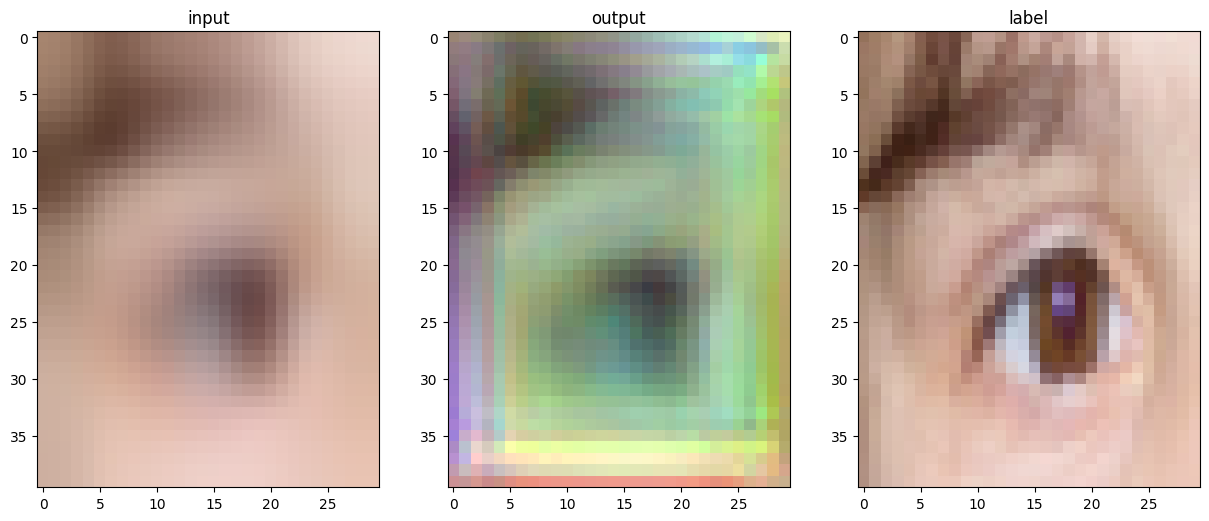

PSNR
input: 22.88217109917239 output: 16.99988890876692
SSIM
input: 0.9999120182974112 output: 0.9994219962662887


In [ ]:
#inference
for img , label in new_valid_loader:
    img= img[1]
    label = label[1]
    break

model.eval()
with torch. no_grad():
    img_ = img.unsqueeze(0).to(device)
    output = model(img_)
    output = output.squeeze(0)
output_visualization(img,output,label,nor_mean,nor_std)

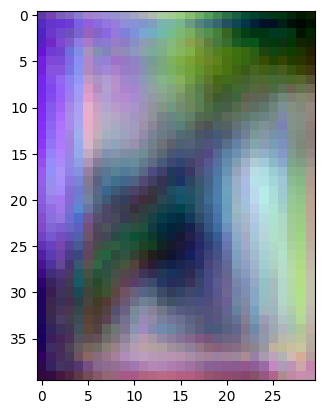

In [ ]:
model.eval()
with torch. no_grad():
    img_ = lr_img.unsqueeze(0)
    img_ = img_.to(device)
    output = model(img_)
    output = output.squeeze(0)
#output_visualization(img,output,label,nor_mean,nor_std)
imshow(output,nor_mean,nor_std)